# Portuguese Bank Marketing Data, SVM with and without Exhaustive Grid Search

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
bank_data=pd.read_csv("./data/portugese-banking/bank-full.csv",sep=';')
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Represent data in fully numerical format
replace_struct={"marital": {"single":0 ,"married":1,"divorced":2},
                "contact": {"unknown":0,"telephone":1,"cellular":2},
                "month": {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12},
                "default":{"yes":1, "no":0},
                "loan":{"yes":1, "no":0},
                "housing":{"yes":1, "no":0},
                "Target": {"no":0,"yes":1}
                }
                
data_df = bank_data.replace(replace_struct)

data_df= data_df.drop(data_df[data_df['education']=='unknown'].index, axis=0)
data_df= data_df.drop(data_df[data_df['job']=='unknown'].index, axis=0)
print(data_df.shape)

data_df = data_df.drop(['pdays','poutcome', 'default'],axis=1) #not significant in classifying the customer
print(data_df.shape)
oneHotcode =['job','education']
data_df = pd.get_dummies(data_df, columns=oneHotcode)
print(data_df.shape)
labels = ["TD not bought", "TD bought"]

(43193, 17)
(43193, 14)
(43193, 26)


In [4]:
x = data_df.drop(['y'], axis=1)
y = data_df['y']
X_train, x_test, Y_train, y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, random_state = 1)

In [5]:
def make_report(gt_list, pred_list, labels, data_type="Training"):
    print("%s metrics: " % (data_type))
    print("Sample count %d" %(len(gt_list)))
    print("Percent %s accuracy %d" %(data_type, 100 * accuracy_score(gt_list, pred_list)))
    print("%s confusion metrics: " %(data_type))
    ConfusionMatrixDisplay.from_predictions(gt_list, 
                                                 pred_list, 
                                                 display_labels=labels, 
                                                 xticks_rotation="vertical"
                                            )
    plt.tight_layout()
    plt.show()

# Support Vector Machines (SVMs)

SVMs are a type of supervised machine learning algorithm that can be used for classification and regression tasks.

The SVM algorithm works by finding the hyperplane that separates the different classes in the feature space. The key idea behind SVMs is to find the hyperplane that maximizes the margin, which is the distance between the closest points of the different classes. The points that are closest to the hyperplane are called support vectors. 

One of the main advantages of using SVMs for image classification is that they can effectively handle high-dimensional data, such as images. Additionally, SVMs are less prone to overfitting than other algorithms. 

Some of the key parameters in SVM are:
- Gamma : defines how far the influence of single training examples reaches values leads to biased results.

- C : Controls the cost of miscalculations

        Small C —> makes the cost of misclassification LOW

        Large C —> makes the cost of misclassification HIGH

- Kernel : SVM algorithms use a set of mathematical functions that are defined as the kernel.
Types of Kernels are: Linear, Radial Basis Function (RBF), Polynomial, etc.

    Hyperplane visualization
    
    ![Alt text](data/svm-hyperplane.png)

Training metrics: 
Sample count 30235
Percent Training accuracy 88
Training confusion metrics: 


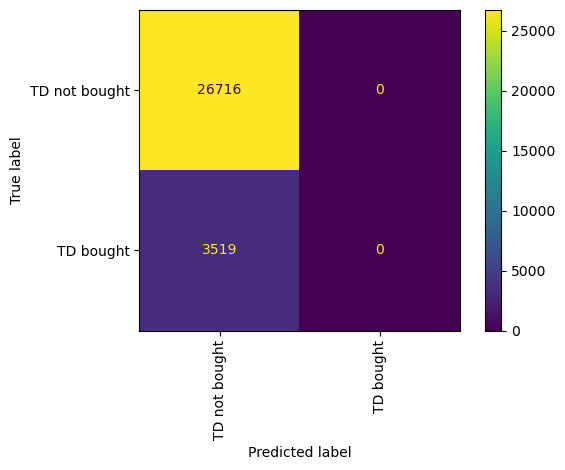

Test metrics: 
Sample count 12958
Percent Test accuracy 88
Test confusion metrics: 


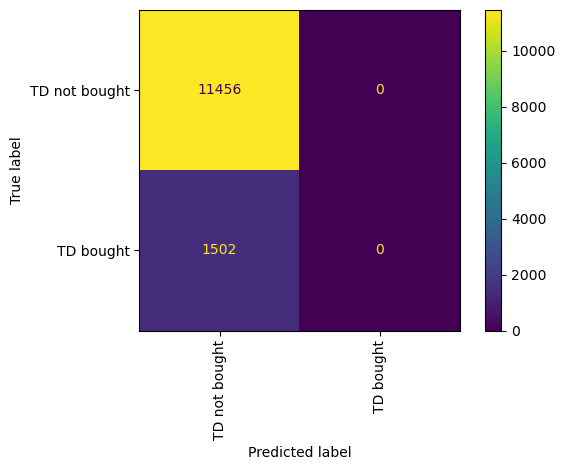

In [10]:
from sklearn import svm

# Creating a support vector classifier
svc = svm.SVC(C = 0.1, kernel='rbf', gamma= 'auto')
svc.fit(X_train, Y_train)
  
# Check how the training went
y_train_new = svc.predict(X_train)
y_test_new = svc.predict(x_test)

# Training Reports
make_report(gt_list=Y_train, pred_list=y_train_new, labels=labels, data_type="Training")
make_report(gt_list=y_test, pred_list=y_test_new, labels=labels, data_type="Test")

### Hyper-parameter Tuning : Exhaustive Grid Search

All possible combinations from param_grid will be used to train candidates. Best candidate among them is chosen based on user defined 'scoring' strategy. Else the estimator being passed (here SVM) must have a method that exactly matches score( ). While tuning, by default 5 fold validation is done unless otherwise instructed.

In [6]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.1, 1, 10],
            'gamma':[ 0.001, 0.1, 1],
            'kernel':['rbf']}

svc = svm.SVC()
model = GridSearchCV(svc, param_grid, scoring='accuracy')

model.fit(X_train, Y_train)


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='accuracy')

Best score for GridSearchCV is 88.361
Best params combination: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Test metrics: 
Sample count 12958
Percent Test accuracy 88
Test confusion metrics: 


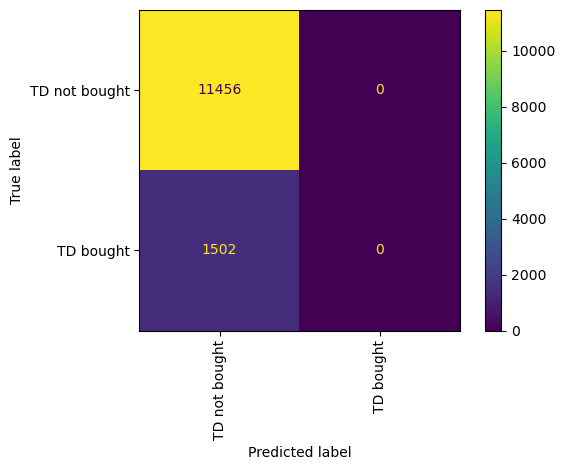

In [8]:
# https://medium.com/dvt-engineering/hyper-parameter-tuning-for-scikit-learn-ml-models-860747bc3d72

# took 180 minutes to complete grid search
results = pd.DataFrame(model.cv_results_)
results.loc[:, 'mean_test_score'] *= 100

# take the most relevant columns and sort (for readability)
results = results.loc[:, ('rank_test_score', 'mean_test_score', 'params')]
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
    
score = results['mean_test_score'].iloc[0]
params = results['params'].iloc[0]

print(f'Best score for GridSearchCV is {score:.3f}')
print(f'Best params combination: {params}')
    
# Check how the training went
y_test_new = model.predict(x_test)

# Training Reports
make_report(gt_list=y_test, pred_list=y_test_new, labels=labels, data_type="Test")

